In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import glob
from tqdm import tqdm

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check for GPU availability
print("GPU Available: ", len(tf.config.list_physical_devices('GPU')) > 0)
print(f"TensorFlow version: {tf.__version__}")

NADIR_DIR = "/kaggle/input/nadir-clean"
OBLIQUE_DIR = "/kaggle/input/oblique-clean"

# Output directories
MODEL_SAVE_DIR = "models"
PLOT_SAVE_DIR = "plots"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

# Model configuration
BATCH_SIZE = 32
IMG_SIZE = 224  # Common input size for most models
EPOCHS = 50
CLASS_NAMES = ["Spruce", "Pine", "Birch"]
NUM_CLASSES = len(CLASS_NAMES)

# Data preparation functions
def create_dataset_from_split_folders(base_dir, split_type):
    """
    Create dataset from pre-split folders (train/val/test)
    Each split contains class folders (Spruce/Pine/Birch)
    """
    split_dir = os.path.join(base_dir, split_type)
    image_paths = []
    labels = []
    
    # Map class names to indices
    class_to_idx = {class_name: i for i, class_name in enumerate(CLASS_NAMES)}
    
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} does not exist")
            continue
            
        class_idx = class_to_idx[class_name]
        
        for img_path in glob.glob(os.path.join(class_dir, "*.jpg")) + \
                       glob.glob(os.path.join(class_dir, "*.png")) + \
                       glob.glob(os.path.join(class_dir, "*.jpeg")):
            image_paths.append(img_path)
            labels.append(class_idx)
    
    return np.array(image_paths), np.array(labels)

def preprocess_image(image_path, img_size=IMG_SIZE):
    """Load and preprocess image for model input"""
    img = tf.io.read_file(image_path)
    # Handle both JPEG and PNG images
    try:
        img = tf.image.decode_jpeg(img, channels=3)
    except:
        try:
            img = tf.image.decode_png(img, channels=3)
        except:
            print(f"Error decoding image: {image_path}")
            # Return a blank image if decoding fails
            return tf.zeros([img_size, img_size, 3])
    
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.keras.applications.imagenet_utils.preprocess_input(img)  # Normalize using ImageNet stats
    return img

def create_tf_dataset(image_paths, labels, is_training=True):
    """Create a TensorFlow dataset from image paths and labels"""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y),
                         num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Model building functions
def build_convnext_model():
    """Build and compile a ConvNeXt model"""
    base_model = tf.keras.applications.ConvNeXtTiny(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )
    
    model = tf.keras.Sequential([
        base_model,
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_efficientnetv2_model():
    """Build and compile an EfficientNetV2 model"""
    base_model = tf.keras.applications.EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )
    
    model = tf.keras.Sequential([
        base_model,
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_resnet_model():
    """Build and compile a ResNet50V2 model"""
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )
    
    model = tf.keras.Sequential([
        base_model,
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_densenet_model():
    """Build and compile a DenseNet121 model"""
    base_model = tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )
    
    model = tf.keras.Sequential([
        base_model,
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

2025-07-27 03:06:19.247690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753585579.401467      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753585579.445911      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU Available:  True
TensorFlow version: 2.18.0


In [2]:
def train_model(model, train_dataset, val_dataset, model_name, epochs=EPOCHS):
    """Train a model and save the best weights"""
    # Create callbacks
    checkpoint_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}_best.keras")
    model_save_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}.keras")
    
    callbacks = [
        ModelCheckpoint(
            checkpoint_path,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=6,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_SAVE_DIR, f"{model_name}_training_history.png"))
    plt.close()
    
    # Load best weights
    model.load_weights(checkpoint_path)
    
    # Save the complete model (architecture + weights)
    model.save(model_save_path)
    print(f"Model saved to: {model_save_path}")
    
    # Save training history to CSV
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(os.path.join(PLOT_SAVE_DIR, f"{model_name}_history.csv"), index=False)
    
    return model, history

def evaluate_model(model, test_dataset, model_name):
    """Evaluate model performance on test set"""
    # Get predictions
    true_labels = []
    for _, y in test_dataset:
        true_labels.extend(y.numpy())
    y_true = np.array(true_labels)
    
    y_pred = np.argmax(model.predict(test_dataset), axis=1)
    
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"{model_name} Test Accuracy: {acc:.4f}")
    print(f"{model_name} Test F1 Score: {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    
    # Add class labels to axes
    tick_marks = np.arange(len(CLASS_NAMES))
    plt.xticks(tick_marks, CLASS_NAMES, rotation=45)
    plt.yticks(tick_marks, CLASS_NAMES)
    
    # Add count values to cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(PLOT_SAVE_DIR, f"{model_name}_confusion_matrix.png"))
    plt.close()
    
    # Save metrics to CSV
    metrics_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [acc],
        'F1_Score': [f1]
    })
    metrics_df.to_csv(os.path.join(PLOT_SAVE_DIR, f"{model_name}_metrics.csv"), index=False)
    
    return {'accuracy': acc, 'f1_score': f1, 'confusion_matrix': cm}


In [3]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Helper Functions ===
def get_predictions_and_labels(model, dataset):
    y_true, y_pred = [], []
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(labels.numpy())
    return np.array(y_true), np.array(y_pred)

def print_classification_report(model, dataset, model_name):
    y_true, y_pred = get_predictions_and_labels(model, dataset)
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
    print(f"\n📋 Classification Report: {model_name}")
    print(report)

def plot_confusion_matrix_inline(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [4]:
# 1. Prepare data for nadir images
print("Preparing nadir datasets...")

nadir_train_paths, nadir_train_labels = create_dataset_from_split_folders(NADIR_DIR, "train")
nadir_val_paths, nadir_val_labels = create_dataset_from_split_folders(NADIR_DIR, "val")
nadir_test_paths, nadir_test_labels = create_dataset_from_split_folders(NADIR_DIR, "test")

print(f"Nadir Images - Train: {len(nadir_train_paths)}, Val: {len(nadir_val_paths)}, Test: {len(nadir_test_paths)}")

# Create TF datasets for nadir images
nadir_train_dataset = create_tf_dataset(nadir_train_paths, nadir_train_labels, is_training=True)
nadir_val_dataset = create_tf_dataset(nadir_val_paths, nadir_val_labels, is_training=False)
nadir_test_dataset = create_tf_dataset(nadir_test_paths, nadir_test_labels, is_training=False)

Preparing nadir datasets...
Nadir Images - Train: 10129, Val: 2893, Test: 1449


I0000 00:00:1753585607.868035      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
print("Preparing oblique datasets...")

oblique_train_paths, oblique_train_labels = create_dataset_from_split_folders(OBLIQUE_DIR, "train")
oblique_val_paths, oblique_val_labels = create_dataset_from_split_folders(OBLIQUE_DIR, "val")
oblique_test_paths, oblique_test_labels = create_dataset_from_split_folders(OBLIQUE_DIR, "test")

print(f"Oblique Images - Train: {len(oblique_train_paths)}, Val: {len(oblique_val_paths)}, Test: {len(oblique_test_paths)}")

# Create TF datasets for oblique images
oblique_train_dataset = create_tf_dataset(oblique_train_paths, oblique_train_labels, is_training=True)
oblique_val_dataset = create_tf_dataset(oblique_val_paths, oblique_val_labels, is_training=False)
oblique_test_dataset = create_tf_dataset(oblique_test_paths, oblique_test_labels, is_training=False)

Preparing oblique datasets...
Oblique Images - Train: 6981, Val: 1994, Test: 1000


In [6]:
print("\nTraining nadir models...")

# Train ConvNeXt model
print("Training ConvNeXt model on nadir images...")
convnext_model = build_convnext_model()
convnext_model, convnext_history = train_model(
    convnext_model, nadir_train_dataset, nadir_val_dataset, "convnext_nadir"
)
convnext_metrics = evaluate_model(convnext_model, nadir_test_dataset, "ConvNeXt (Nadir)")


Training nadir models...
Training ConvNeXt model on nadir images...
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50


I0000 00:00:1753585665.768532      93 service.cc:148] XLA service 0x7b01a800d320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753585665.769413      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753585669.615043      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1753585673.412012      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753585673.588602      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753585673.833052      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753585674.0279

316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7535 - loss: 0.6144

E0000 00:00:1753585801.888733      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753585802.067001      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753585802.313047      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753585802.508177      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7538 - loss: 0.6139
Epoch 1: val_accuracy improved from -inf to 0.88317, saving model to models/convnext_nadir_best.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 204s 451ms/step - accuracy: 0.7540 - loss: 0.6134 - val_accuracy: 0.8832 - val_loss: 0.3335 - learning_rate: 1.0000e-04
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9050 - loss: 0.2762
Epoch 2: val_accuracy improved from 0.88317 to 0.90010, saving model to models/convnext_nadir_best.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 119s 376ms/step - accuracy: 0.9050 - loss: 0.2762 - val_accuracy: 0.9001 - val_loss: 0.2850 - learning_rate: 1.0000e-04
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9286 - loss: 0.2091
Epoch 3: val_accuracy improved from 0.90010 to 0.90149, saving model to models/convnext_nadir_best.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 119s 376ms/step - accuracy: 0.9286 - loss: 0.2091 - val_accuracy: 0.9015 - val_loss: 0.2925 - learning_rate:

In [7]:
# ConvNeXt (Nadir) Test Accuracy: 0.9144
# ConvNeXt (Nadir) Test F1 Score: 0.9145

print_classification_report(convnext_model, nadir_test_dataset, "ConvNeXt (Nadir)")


📋 Classification Report: ConvNeXt (Nadir)
              precision    recall  f1-score   support

      Spruce     0.9395    0.9236    0.9315       471
        Pine     0.9112    0.8927    0.9018       494
       Birch     0.8944    0.9277    0.9108       484

    accuracy                         0.9144      1449
   macro avg     0.9150    0.9147    0.9147      1449
weighted avg     0.9148    0.9144    0.9145      1449



32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step
ConvNeXt (Nadir→Oblique) Test Accuracy: 0.5840
ConvNeXt (Nadir→Oblique) Test F1 Score: 0.5825

ConvNeXt Accuracy: 58.40%, F1: 0.5825


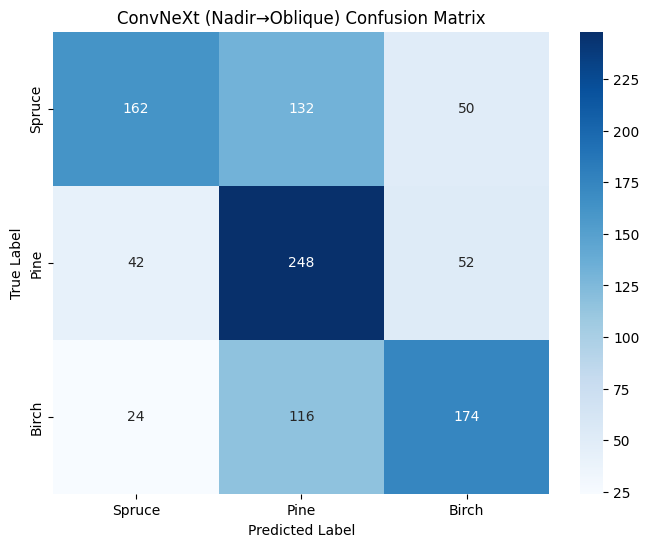

In [8]:
conv_model = load_model("models/convnext_nadir_best.keras")

conv_metrics = evaluate_model(conv_model, oblique_test_dataset, "ConvNeXt (Nadir→Oblique)")
print(f"\nConvNeXt Accuracy: {conv_metrics['accuracy']*100:.2f}%, F1: {conv_metrics['f1_score']:.4f}")
plot_confusion_matrix_inline(conv_metrics['confusion_matrix'], "ConvNeXt (Nadir→Oblique)")


In [9]:
# Train EfficientNetV2 model
print("Training EfficientNetV2 model on nadir images...")
efficientnet_model = build_efficientnetv2_model()
efficientnet_model, efficientnet_history = train_model(
    efficientnet_model, nadir_train_dataset, nadir_val_dataset, "efficientnet_nadir"
)
efficientnet_metrics = evaluate_model(efficientnet_model, nadir_test_dataset, "EfficientNetV2 (Nadir)")

Training EfficientNetV2 model on nadir images...
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50


E0000 00:00:1753588082.579006      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753588082.768612      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753588083.248773      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753588083.449608      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753588084.003578      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7468 - loss: 0.6106

E0000 00:00:1753588209.648156      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753588209.837787      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753588210.243926      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753588210.443721      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753588210.979849      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7470 - loss: 0.6101
Epoch 1: val_accuracy improved from -inf to 0.89526, saving model to models/efficientnet_nadir_best.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 337s 486ms/step - accuracy: 0.7473 - loss: 0.6096 - val_accuracy: 0.8953 - val_loss: 0.3055 - learning_rate: 1.0000e-04
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9181 - loss: 0.2438
Epoch 2: val_accuracy improved from 0.89526 to 0.90045, saving model to models/efficientnet_nadir_best.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 74s 233ms/step - accuracy: 0.9181 - loss: 0.2438 - val_accuracy: 0.9004 - val_loss: 0.3215 - learning_rate: 1.0000e-04
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9398 - loss: 0.1642
Epoch 3: val_accuracy did not improve from 0.90045
317/317 ━━━━━━━━━━━━━━━━━━━━ 71s 223ms/step - accuracy: 0.9398 - loss: 0.1642 - val_accuracy: 0.8966 - val_loss: 0.3663 - learning_rate: 1.0000e-04
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━

In [10]:
# EfficientNetV2 (Nadir) Test Accuracy: 0.9137
# EfficientNetV2 (Nadir) Test F1 Score: 0.9138

print_classification_report(efficientnet_model, nadir_test_dataset, "EfficientNetV2 (Nadir)")


📋 Classification Report: EfficientNetV2 (Nadir)
              precision    recall  f1-score   support

      Spruce     0.9315    0.9236    0.9275       471
        Pine     0.9210    0.8968    0.9087       494
       Birch     0.8902    0.9215    0.9056       484

    accuracy                         0.9137      1449
   macro avg     0.9142    0.9139    0.9139      1449
weighted avg     0.9141    0.9137    0.9138      1449



32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 523ms/step
EfficientNetV2 (Nadir→Oblique) Test Accuracy: 0.6000
EfficientNetV2 (Nadir→Oblique) Test F1 Score: 0.5937

EfficientNetV2 Accuracy: 60.00%, F1: 0.5937


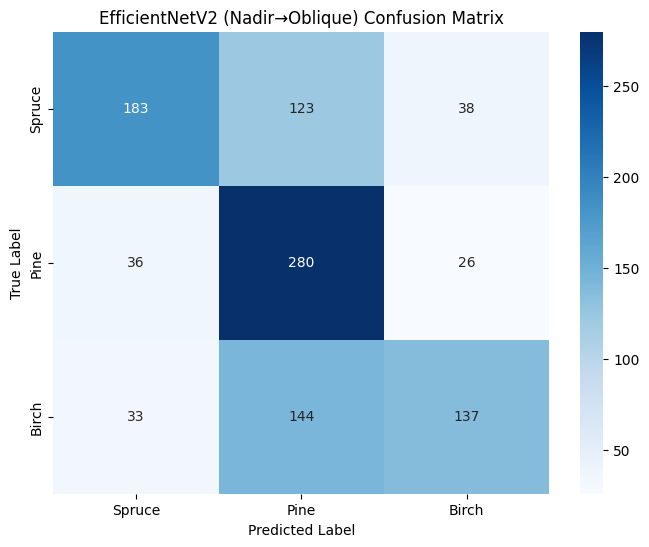

In [11]:
eff_model = load_model("models/efficientnet_nadir_best.keras")

eff_metrics = evaluate_model(eff_model, oblique_test_dataset, "EfficientNetV2 (Nadir→Oblique)")
print(f"\nEfficientNetV2 Accuracy: {eff_metrics['accuracy']*100:.2f}%, F1: {eff_metrics['f1_score']:.4f}")
plot_confusion_matrix_inline(eff_metrics['confusion_matrix'], "EfficientNetV2 (Nadir→Oblique)")

In [15]:
print("\nTraining oblique models...")

# Train ResNet model
print("Training ResNet model on oblique images...")
resnet_model = build_resnet_model()
resnet_model, resnet_history = train_model(
    resnet_model, oblique_train_dataset, oblique_val_dataset, "resnet50v2_oblique"
)
resnet_metrics = evaluate_model(resnet_model, oblique_test_dataset, "ResNet50V2 (Oblique)")


Training oblique models...
Training ResNet model on oblique images...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6868 - loss: 0.6908
Epoch 1: val_accuracy improved from -inf to 0.86058, saving model to models/resnet50v2_oblique_best.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 130s 287ms/step - accuracy: 0.6872 - loss: 0.6901 - val_accuracy: 0.8606 - val_loss: 0.4139 - learning_rate: 1.0000e-04
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9067 - loss: 0.2515
Epoch 2: val_accuracy did not improve from 0.86058
219/219 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - accuracy: 0.9067 - loss: 0.2515 - val_accuracy: 0.8586 - val_loss: 0.4532 - learning_rate: 1.0000e-04
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9536 - loss: 0.1236
Epoch 3: val_accuracy did not improve from 0.86058
219/219 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.9535 - loss: 0.1237 - val_accuracy: 0.8495 - val_lo

In [16]:
# ResNet50V2 (Oblique) Test Accuracy: 0.8840
# ResNet50V2 (Oblique) Test F1 Score: 0.8831

print_classification_report(resnet_model, oblique_test_dataset, "ResNet50V2 (Oblique)")


📋 Classification Report: ResNet50V2 (Oblique)
              precision    recall  f1-score   support

      Spruce     0.9029    0.9186    0.9107       344
        Pine     0.8954    0.8012    0.8457       342
       Birch     0.8547    0.9363    0.8936       314

    accuracy                         0.8840      1000
   macro avg     0.8843    0.8854    0.8833      1000
weighted avg     0.8852    0.8840    0.8831      1000



46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step
ResNet50V2 (Oblique→Nadir) Test Accuracy: 0.5521
ResNet50V2 (Oblique→Nadir) Test F1 Score: 0.5497

ResNet50V2 Accuracy: 55.21%, F1: 0.5497


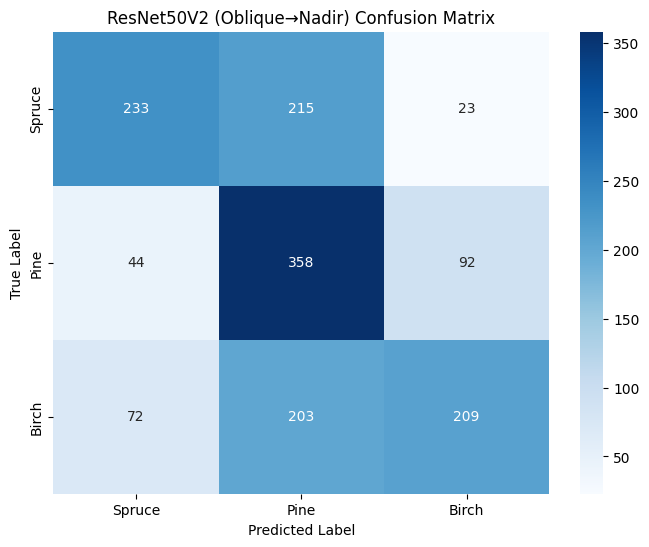

In [17]:
resnet_model = load_model("models/resnet50v2_oblique_best.keras")

resnet_metrics = evaluate_model(resnet_model, nadir_test_dataset, "ResNet50V2 (Oblique→Nadir)")
print(f"\nResNet50V2 Accuracy: {resnet_metrics['accuracy']*100:.2f}%, F1: {resnet_metrics['f1_score']:.4f}")
plot_confusion_matrix_inline(resnet_metrics['confusion_matrix'], "ResNet50V2 (Oblique→Nadir)")

In [19]:
# Train DenseNet model
print("Training DenseNet model on oblique images...")
densenet_model = build_densenet_model()
densenet_model, densenet_history = train_model(
    densenet_model, oblique_train_dataset, oblique_val_dataset, "densenet121_oblique"
)
densenet_metrics = evaluate_model(densenet_model, oblique_test_dataset, "DenseNet121 (Oblique)")

Training DenseNet model on oblique images...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.6875 - loss: 0.7187
Epoch 1: val_accuracy improved from -inf to 0.86008, saving model to models/densenet121_oblique_best.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 341s 691ms/step - accuracy: 0.6879 - loss: 0.7180 - val_accuracy: 0.8601 - val_loss: 0.3591 - learning_rate: 1.0000e-04
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8931 - loss: 0.2960
Epoch 2: val_accuracy did not improve from 0.86008
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 176ms/step - accuracy: 0.8931 - loss: 0.2960 - val_accuracy: 0.8536 - val_loss: 0.3673 - learning_rate: 1.0000e-04
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9316 - loss: 0.1886
Epoch 3: val_accuracy improved from 0.86008 to 0.87663, saving model to models/densenet121_oblique_best.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.9316 - loss: 0.18

In [20]:
# DenseNet121 (Oblique) Test Accuracy: 0.8810
# DenseNet121 (Oblique) Test F1 Score: 0.8806

print_classification_report(densenet_model, oblique_test_dataset, "DenseNet121 (Oblique)")


📋 Classification Report: DenseNet121 (Oblique)
              precision    recall  f1-score   support

      Spruce     0.9222    0.8953    0.9086       344
        Pine     0.8521    0.8421    0.8471       342
       Birch     0.8689    0.9076    0.8879       314

    accuracy                         0.8810      1000
   macro avg     0.8810    0.8817    0.8812      1000
weighted avg     0.8815    0.8810    0.8810      1000



46/46 ━━━━━━━━━━━━━━━━━━━━ 27s 358ms/step
DenseNet121 (Oblique→Nadir) Test Accuracy: 0.5169
DenseNet121 (Oblique→Nadir) Test F1 Score: 0.5026

DenseNet121 Accuracy: 51.69%, F1: 0.5026


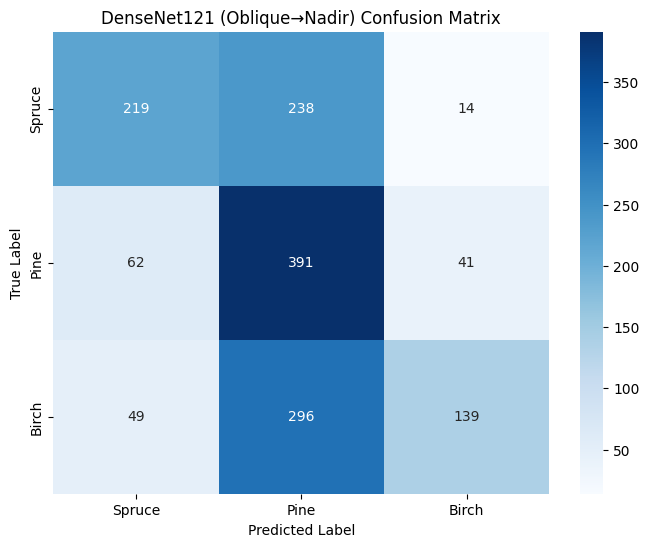

In [21]:
densenet_model = load_model("models/densenet121_oblique_best.keras")

densenet_metrics = evaluate_model(densenet_model, nadir_test_dataset, "DenseNet121 (Oblique→Nadir)")
print(f"\nDenseNet121 Accuracy: {densenet_metrics['accuracy']*100:.2f}%, F1: {densenet_metrics['f1_score']:.4f}")
plot_confusion_matrix_inline(densenet_metrics['confusion_matrix'], "DenseNet121 (Oblique→Nadir)")

In [27]:
# === Build the fusion model using EfficientNetV2 (nadir) + DenseNet121 (oblique) ===
print("Building fusion model using EfficientNetV2 (nadir) + DenseNet121 (oblique)...")

# Load base models without classification heads
efficientnet_base = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling='avg'
)

densenet_base = tf.keras.applications.DenseNet121(
    include_top=False,
    weights=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling='avg'
)

# Load the trained model weights
efficientnet_model.load_weights(os.path.join(MODEL_SAVE_DIR, "efficientnet_nadir_best.keras"))
densenet_model.load_weights(os.path.join(MODEL_SAVE_DIR, "densenet121_oblique_best.keras"))

# Set weights of base models from trained models (1st layer in each Sequential)
efficientnet_base.set_weights(efficientnet_model.layers[0].get_weights())
densenet_base.set_weights(densenet_model.layers[0].get_weights())

# Create fusion model
fusion_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
eff_features = efficientnet_base(fusion_input)
dense_features = densenet_base(fusion_input)
fusion_features = layers.concatenate([eff_features, dense_features])

x = layers.Dense(1024, activation='relu')(fusion_features)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

fusion_model = models.Model(inputs=fusion_input, outputs=output)

fusion_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Building fusion model using EfficientNetV2 (nadir) + DenseNet121 (oblique)...


In [29]:
print("Preparing combined training and validation datasets...")

combined_train_paths = np.concatenate([nadir_train_paths, oblique_train_paths])
combined_train_labels = np.concatenate([nadir_train_labels, oblique_train_labels])

combined_val_paths = np.concatenate([nadir_val_paths, oblique_val_paths])
combined_val_labels = np.concatenate([nadir_val_labels, oblique_val_labels])

# TensorFlow datasets
fusion_train_dataset = create_tf_dataset(combined_train_paths, combined_train_labels, is_training=True)
fusion_val_dataset = create_tf_dataset(combined_val_paths, combined_val_labels, is_training=False)


Preparing combined training and validation datasets...


In [30]:
print("Training fusion model (EfficientNetV2 + DenseNet121)...")

fusion_model, fusion_history = train_model(
    fusion_model,
    fusion_train_dataset,
    fusion_val_dataset,
    model_name="fusion_efficientnet_densenet"
)


Training fusion model (EfficientNetV2 + DenseNet121)...
Epoch 1/50
534/535 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9078 - loss: 0.2437

E0000 00:00:1753593481.607185      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753593481.797342      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753593482.245725      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753593482.446123      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753593483.037715      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.9079 - loss: 0.2436
Epoch 1: val_accuracy improved from -inf to 0.87559, saving model to models/fusion_efficientnet_densenet_best.keras
535/535 ━━━━━━━━━━━━━━━━━━━━ 854s 888ms/step - accuracy: 0.9079 - loss: 0.2435 - val_accuracy: 0.8756 - val_loss: 0.4412 - learning_rate: 1.0000e-04
Epoch 2/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9659 - loss: 0.0950
Epoch 2: val_accuracy improved from 0.87559 to 0.88971, saving model to models/fusion_efficientnet_densenet_best.keras
535/535 ━━━━━━━━━━━━━━━━━━━━ 218s 408ms/step - accuracy: 0.9659 - loss: 0.0950 - val_accuracy: 0.8897 - val_loss: 0.4591 - learning_rate: 1.0000e-04
Epoch 3/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9735 - loss: 0.0742
Epoch 3: val_accuracy did not improve from 0.88971
535/535 ━━━━━━━━━━━━━━━━━━━━ 213s 398ms/step - accuracy: 0.9735 - loss: 0.0742 - val_accuracy: 0.8701 - val_loss: 0.5765 - learning_rate: 1.0000e-04
Epoch 4/50
535

In [31]:
combined_test_paths = np.concatenate([nadir_test_paths, oblique_test_paths])
combined_test_labels = np.concatenate([nadir_test_labels, oblique_test_labels])
fusion_test_dataset = create_tf_dataset(combined_test_paths, combined_test_labels, is_training=False)

fusion_metrics = evaluate_model(fusion_model, fusion_test_dataset, "Fusion (EfficientNetV2 + DenseNet121)")


77/77 ━━━━━━━━━━━━━━━━━━━━ 67s 475ms/step
Fusion (EfficientNetV2 + DenseNet121) Test Accuracy: 0.9008
Fusion (EfficientNetV2 + DenseNet121) Test F1 Score: 0.9004


In [32]:
# Fusion (EfficientNetV2 + DenseNet121) Test Accuracy: 0.9008
# Fusion (EfficientNetV2 + DenseNet121) Test F1 Score: 0.9004

print_classification_report(fusion_model, fusion_test_dataset, "Fusion (EfficientNetV2 + DenseNet121)")


📋 Classification Report: Fusion (EfficientNetV2 + DenseNet121)
              precision    recall  f1-score   support

      Spruce     0.9068    0.9313    0.9189       815
        Pine     0.9127    0.8505    0.8805       836
       Birch     0.8836    0.9223    0.9025       798

    accuracy                         0.9008      2449
   macro avg     0.9010    0.9014    0.9006      2449
weighted avg     0.9012    0.9008    0.9004      2449



In [35]:
def predict_image_class(img_path, model=fusion_model, class_names=CLASS_NAMES, img_size=IMG_SIZE):
    # Read and decode image
    img = tf.io.read_file(img_path)
    try:
        img = tf.image.decode_jpeg(img, channels=3)
    except:
        img = tf.image.decode_png(img, channels=3)

    # Resize and preprocess
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.keras.applications.imagenet_utils.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)

    # Predict
    preds = model.predict(img)
    pred_idx = tf.argmax(preds[0]).numpy()
    pred_class = class_names[pred_idx]
    confidence = preds[0][pred_idx]

    print(f"Image: {os.path.basename(img_path)}")
    print(f"Predicted class: {pred_class} (confidence: {confidence:.2f})\n")

    return pred_class


In [36]:
predict_image_class("/kaggle/input/nadir-clean/train/Birch/0017f912-e89a-436b-9d4f-255a2892749d_Birch_642_738.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Image: 0017f912-e89a-436b-9d4f-255a2892749d_Birch_642_738.jpg
Predicted class: Birch (confidence: 1.00)



'Birch'

In [37]:
predict_image_class("/kaggle/input/nadir-clean/train/Pine/0017f912-e89a-436b-9d4f-255a2892749d_Pine_1291_441.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image: 0017f912-e89a-436b-9d4f-255a2892749d_Pine_1291_441.jpg
Predicted class: Pine (confidence: 1.00)



'Pine'

In [38]:
predict_image_class("/kaggle/input/nadir-clean/train/Spruce/01798d0d-af36-442d-89f3-a1e0626646ab_Spruce_467_1396.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image: 01798d0d-af36-442d-89f3-a1e0626646ab_Spruce_467_1396.jpg
Predicted class: Spruce (confidence: 1.00)



'Spruce'

In [39]:
predict_image_class("/kaggle/input/oblique-clean/test/Birch/0349720a-7d75-4dd5-95e6-b96d551d88ed_Birch_1440_107.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Image: 0349720a-7d75-4dd5-95e6-b96d551d88ed_Birch_1440_107.jpg
Predicted class: Birch (confidence: 0.99)



'Birch'

In [40]:
predict_image_class("/kaggle/input/oblique-clean/test/Spruce/0577003b-ede5-4d99-9666-792f3682edfb_Spruce_1132_433.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Image: 0577003b-ede5-4d99-9666-792f3682edfb_Spruce_1132_433.jpg
Predicted class: Spruce (confidence: 0.72)



'Spruce'

In [41]:
predict_image_class("/kaggle/input/oblique-clean/test/Pine/0489c643-44fb-49b1-8b0a-7e563efeecd7_Pine_1085_76.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image: 0489c643-44fb-49b1-8b0a-7e563efeecd7_Pine_1085_76.jpg
Predicted class: Pine (confidence: 0.97)



'Pine'

In [12]:
SNOW_DIR = "/kaggle/input/snow-clean-images"
snow_image_paths, snow_labels = create_dataset_from_split_folders(SNOW_DIR, split_type="")  # "" uses root directly
snow_dataset = create_tf_dataset(snow_image_paths, snow_labels, is_training=False)

In [13]:
# === Evaluate ConvNeXt (Nadir) on Snow Images ===
convnext_snow_metrics = evaluate_model(convnext_model, snow_dataset, "ConvNeXt (Nadir→Snow)")
print_classification_report(convnext_model, snow_dataset, "ConvNeXt (Nadir→Snow)")

375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step
ConvNeXt (Nadir→Snow) Test Accuracy: 0.2223
ConvNeXt (Nadir→Snow) Test F1 Score: 0.2074

📋 Classification Report: ConvNeXt (Nadir→Snow)
              precision    recall  f1-score   support

      Spruce     0.7925    0.6605    0.7205      2898
        Pine     0.7051    0.0196    0.0381      8422
       Birch     0.0629    0.8711    0.1174       675

    accuracy                         0.2223     11995
   macro avg     0.5202    0.5171    0.2920     11995
weighted avg     0.6901    0.2223    0.2074     11995



In [14]:
# === Evaluate EfficientNetV2 (Nadir) on Snow Images ===
efficientnet_snow_metrics = evaluate_model(efficientnet_model, snow_dataset, "EfficientNetV2 (Nadir→Snow)")
print_classification_report(efficientnet_model, snow_dataset, "EfficientNetV2 (Nadir→Snow)")

375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step
EfficientNetV2 (Nadir→Snow) Test Accuracy: 0.1920
EfficientNetV2 (Nadir→Snow) Test F1 Score: 0.2054

📋 Classification Report: EfficientNetV2 (Nadir→Snow)
              precision    recall  f1-score   support

      Spruce     0.8507    0.5173    0.6433      2898
        Pine     0.6755    0.0331    0.0632      8422
       Birch     0.0535    0.7778    0.1000       675

    accuracy                         0.1920     11995
   macro avg     0.5266    0.4427    0.2689     11995
weighted avg     0.6829    0.1920    0.2054     11995



In [18]:
# === Evaluate ResNet50V2 (Oblique) on Snow Images ===
resnet_snow_metrics = evaluate_model(resnet_model, snow_dataset, "ResNet50V2 (Oblique→Snow)")
print_classification_report(resnet_model, snow_dataset, "ResNet50V2 (Oblique→Snow)")

375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step
ResNet50V2 (Oblique→Snow) Test Accuracy: 0.5916
ResNet50V2 (Oblique→Snow) Test F1 Score: 0.6300

📋 Classification Report: ResNet50V2 (Oblique→Snow)
              precision    recall  f1-score   support

      Spruce     0.5784    0.5728    0.5756      2898
        Pine     0.8151    0.5758    0.6748      8422
       Birch     0.1848    0.8696    0.3049       675

    accuracy                         0.5916     11995
   macro avg     0.5261    0.6727    0.5184     11995
weighted avg     0.7224    0.5916    0.6300     11995



In [22]:
# === Evaluate DenseNet121 (Oblique) on Snow Images ===
densenet_snow_metrics = evaluate_model(densenet_model, snow_dataset, "DenseNet121 (Oblique→Snow)")
print_classification_report(densenet_model, snow_dataset, "DenseNet121 (Oblique→Snow)")

375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step
DenseNet121 (Oblique→Snow) Test Accuracy: 0.6876
DenseNet121 (Oblique→Snow) Test F1 Score: 0.6886

📋 Classification Report: DenseNet121 (Oblique→Snow)
              precision    recall  f1-score   support

      Spruce     0.5356    0.4055    0.4615      2898
        Pine     0.7910    0.7711    0.7809      8422
       Birch     0.3639    0.8578    0.5110       675

    accuracy                         0.6876     11995
   macro avg     0.5635    0.6781    0.5845     11995
weighted avg     0.7052    0.6876    0.6886     11995



In [33]:
fusion_snow_metrics = evaluate_model(fusion_model, snow_dataset, "Fusion (-> Snow)")
print_classification_report(fusion_model, snow_dataset, "Fusion (-> Snow)")

375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 129ms/step
Fusion (-> Snow) Test Accuracy: 0.4688
Fusion (-> Snow) Test F1 Score: 0.5502

📋 Classification Report: Fusion (-> Snow)
              precision    recall  f1-score   support

      Spruce     0.8370    0.6222    0.7138      2898
        Pine     0.8154    0.3861    0.5241      8422
       Birch     0.0970    0.8415    0.1740       675

    accuracy                         0.4688     11995
   macro avg     0.5832    0.6166    0.4706     11995
weighted avg     0.7802    0.4688    0.5502     11995



In [42]:
import shutil

# Path to the folder you want to zip
folder_to_zip = '/kaggle/working/plots'
zip_output_path = "/kaggle/working/FusionModel_plots.zip"

# Create the zip file
shutil.make_archive(base_name=zip_output_path.replace(".zip", ""), format='zip', root_dir=folder_to_zip)

print("Zipping completed. Download from the 'Output' tab.")


Zipping completed. Download from the 'Output' tab.
